In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
from custom_data_loader import *
from torchvision import datasets, transforms
split = "train"
name = "cifar10"
cifar_data_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_set = custom_data_loader(split_name=split, name=name, data_set=cifar_data_set)
print(train_set.x.shape)

Files already downloaded and verified
cifar10_train was loaded
torch.Size([50000, 3, 32, 32])


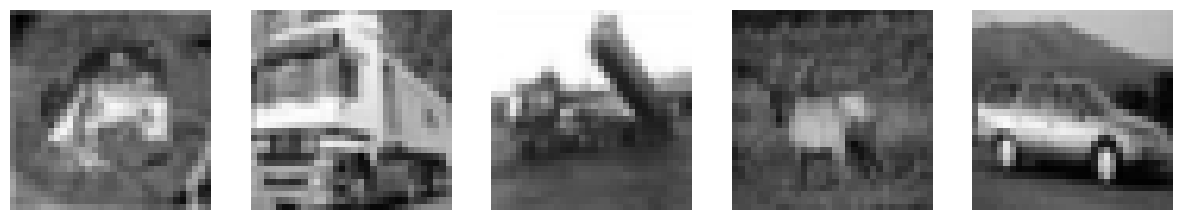

In [3]:
# grayscale
x = train_set.x.mean(dim=1)
x = x.squeeze()
x = torch.reshape(x,  x.shape[:1] + tuple([-1])).numpy()
fig, ax = plt.subplots(1,5)
fig.set_size_inches(15, 3)
for i in range(5):
    ax[i].imshow(x[i,:].reshape(32,32), cmap='gray', vmin=0, vmax=1)
    ax[i].axis("off")

In [4]:
# working but gives very poor results
train_set = custom_data_loader(split_name=split, name=name, data_set=cifar_data_set)
train_set.x = train_set.x.mean(dim=1)
train_set.x = torch.reshape(train_set.x, train_set.x.shape[:1] + tuple([-1])).numpy().astype(np.float64)*2.0 -1.0

#train_set.x = (train_set.x - train_set.x.mean(axis=0)) / train_set.x.std(axis=0)

print(train_set.x.shape)
print(len(train_set))
print("min and max", train_set.x.min(), train_set.x.max())
print("std and mean", train_set.x.std(), train_set.x.mean())


cifar10_train was loaded
(50000, 1024)
50000
min and max -1.0 1.0
std and mean 0.4786046931442118 -0.05327397685482723


(1024, 1024)


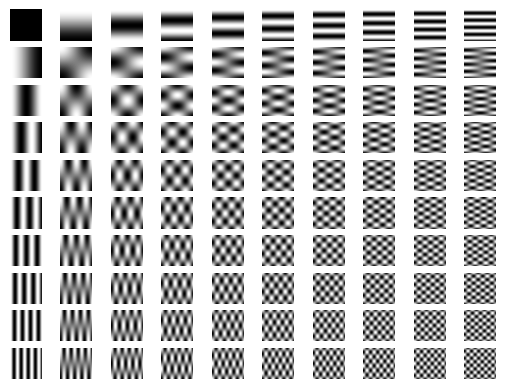

In [5]:

def cosine_features(n=32, m=32):
    di_t = np.zeros((n,m))
    for i in range(n):
        for t in range(m):
            di_t[i,t] = np.cos(t*np.pi*i/n)
    
    #di_t = di_t.T/np.linalg.norm(di_t, axis=1)
    Phi = np.kron(di_t,di_t)
    Phi = Phi / np.linalg.norm(Phi, axis=0)
    print(Phi.shape)
    
    n_first = 10
    fig, axs = plt.subplots(n_first, n_first)
    for i in range(n_first):
        for j in range(n_first):
            axs[j,i].imshow(Phi[:,i*n+j].reshape(m,m), cmap='gray')#, vmin=0, vmax=1)
            axs[j,i].axis('off')
    
    return Phi
            
W = cosine_features()


In [6]:
    
def plot_(diff, err):
    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(1, 2, 1)
    plt.plot(diff)
    plt.yscale("log")
    plt.title("l2 change of z (sparse code)")
    
    fig.add_subplot(1, 2, 2)
    plt.plot(err)
    plt.yscale("log")
    plt.title("l2 err")
    plt.show()
    return 




In [7]:
def plot_W_and_reconst(W, sparse_codes, x_batch, num_plots = 5, seed=None):
    np.random.seed(seed)
    W_n, W_m = W.shape
    res = int(np.sqrt(W_n))
    assert res**2 == W_n
    f, ax = plt.subplots(num_plots, num_plots+1 )
    f.set_figheight(15)
    f.set_figwidth(15)
    plt.tight_layout()
    for ax1 in range(num_plots):
        for ax2 in range(num_plots):
            rand_int = np.random.randint(0,W_m-1)
            ax[ax1, ax2].imshow(W[:,rand_int].reshape(res,res), cmap='gray', vmin=-0.5, vmax=0.5)
            ax[ax1, ax2].set_title("W col "+str(rand_int))
            ax[ax1, ax2].axis('off')

    if x_batch.ndim == 1:
        x = x_batch
    else:
        x = x_batch[0,:]
    ax[0, -1].imshow(x.reshape(res,res), cmap='gray')
    ax[0, -1].set_title("some true x")
    ax[1, -1].imshow((W@sparse_codes[0,:]).reshape(res,res), cmap='gray')
    ax[1, -1].set_title("x reconstruc")
    
    if x_batch.ndim > 1:
        ax[2, -1].imshow(x_batch[1,:].reshape(res,res), cmap='gray')
        ax[2, -1].set_title("some true x")
        ax[3, -1].imshow((W@sparse_codes[1,:]).reshape(res,res), cmap='gray')
        ax[3, -1].set_title("x reconstruc")
        
    ax[0, -1].axis('off')
    ax[1, -1].axis('off')
    ax[2, -1].axis('off')
    ax[3, -1].axis('off')
    ax[4, -1].axis('off')
    
    plt.show()

In [8]:
def print_batch_info(epoch, batch_num, momentum, batch_err, batch_size, sparse_codes):
    zero_elements = np.mean(sparse_codes==0)
    print(f"e: {epoch}, b: {batch_num}, momen: {momentum:.2f}, "
          f"spar: {zero_elements:.3f}, rec err: {batch_err / batch_size:.2f}, "
          f"err/spar: {(batch_err/batch_size) / zero_elements:.2f}")

In [9]:
def compute_A_and_B(sparse_code, train_data):
    A = sparse_code.T @ sparse_code
    B = train_data.T @ sparse_code
    return A, B

def update_W(A, B, W):
    n_attr, n_cols = A.shape
    W_new = W.copy() # to not overwrite the or
    
    for j in range(n_cols):
        val = W[:, j] + (1/A[j,j]) * (B[:,j] - W @ A[:, j])
        val_normed = val / max(np.sqrt(np.sum(val**2)), 1)
        W_new[:, j] = val_normed

    return W_new

In [16]:
from ista_fista_cod import fista, CoD, ista
from joblib import Parallel, delayed
n, m = train_set.x.shape

code_basis_vectors = m
#sparse_codes = np.zeros((code_basis_vectors, n))
W = np.random.normal(size=(m, code_basis_vectors)) # generate random ones
#W = np.copy(train_set.x[:m,:].T) # or use first training examples
#W = torch.load("W_learned_baseline.pt").numpy() # load trained ones
#W = cosine_features(32, 32) # or using cosine features
W = W / np.linalg.norm(W, axis=0) # normalize

A_velocity = np.random.normal(size=(code_basis_vectors, code_basis_vectors) )*0.01   
B_velocity = np.random.normal(size=(m, code_basis_vectors))*0.01  
velocity = np.zeros_like(W)

print("W shape:", W.shape)

W shape: (1024, 1024)


In [11]:
W.shape

(1024, 1024)

In [21]:
import tqdm
alpha = 0.2
nsteps = 500
epochs = 100
batch_size = 100
train_set.set_batch_size(batch_size)
momentum = 0.5
momentum_max = 0.95
momentum_batch_inc = 0.03
actually_plot = False
plot_every_n = max(int(100/batch_size), 1)
lr = 0.0001
sparse_code_func = CoD
method =2
for epoch in range(epochs):
    for batch_num, (x_batch, y_batch) in enumerate(train_set):
        momentum = min(momentum+momentum_batch_inc, momentum_max)
        batch_err = 0.
        sparse_codes = np.zeros((batch_size, code_basis_vectors))
        for j in range(x_batch.shape[0]):
            sparse_codes[j,:], _, _, final_error, _, _ = sparse_code_func(W=W, 
                                                                          x=x_batch[j,:] , 
                                                                          alpha=alpha, 
                                                                          nsteps=nsteps, 
                                                                          verbose=False)             
            batch_err += final_error
        
        # works but isnt faster
        # results = Parallel(n_jobs=6)(delayed(sparse_code_func)
        #                              (W.copy(), x_batch[j,:].copy(), alpha, nsteps, False) for j in range(batch_size))
        # 
        # sparse_codes = np.vstack([results[j][0] for j in range(batch_size)])
        # x_batch = np.vstack([results[j][5] for j in range(batch_size)])
        # batch_err = sum([results[j][3] for j in range(batch_size)])
            
        print_batch_info(epoch, batch_num, momentum, batch_err, batch_size, sparse_codes)
        if batch_num % plot_every_n == 0 and actually_plot:
            _, diff, err, _, _, _ = sparse_code_func(W=W, 
                                                     x=x_batch[0,:] , 
                                                     alpha=alpha, 
                                                     nsteps=nsteps, 
                                                     verbose=True)
            plot_(diff, err)
            plot_W_and_reconst(W, sparse_codes, x_batch, num_plots = 5, seed=None)

        if method==1: #blockwisecoord_descent:
            A, B = compute_A_and_B(sparse_codes, x_batch)
            A_velocity = momentum * A_velocity + A
            B_velocity = momentum * B_velocity + B
            W = update_W(A_velocity, B_velocity, W)
            
        if method==2: #manual gradient descent 
            grad = -(x_batch - (W@sparse_codes.T).T).T @ sparse_codes 
            #dims:              (batch, att)    @   (att, spar) @ (batch, spar) 
            # this line above does the loop below
            # for k in range(batch_size):
            #     grad += np.outer((x_batch[k,:] - W@sparse_codes[k,:]), sparse_codes[k,:])
            grad /= batch_size # calc avg
            velocity = momentum*velocity + grad
            W -= lr * velocity # perform update
            W /= np.sqrt(np.sum(W**2, axis=0))[None,:] # renormalize


e: 0, b: 0, momen: 0.53, spar: 0.837, rec err: 3.96, err/spar: 4.74
e: 0, b: 1, momen: 0.56, spar: 0.857, rec err: 3.85, err/spar: 4.49
e: 0, b: 2, momen: 0.59, spar: 0.856, rec err: 3.78, err/spar: 4.41
e: 0, b: 3, momen: 0.62, spar: 0.858, rec err: 3.78, err/spar: 4.41
e: 0, b: 4, momen: 0.65, spar: 0.844, rec err: 3.88, err/spar: 4.60
e: 0, b: 5, momen: 0.68, spar: 0.856, rec err: 3.85, err/spar: 4.50
e: 0, b: 6, momen: 0.71, spar: 0.861, rec err: 3.86, err/spar: 4.48
e: 0, b: 7, momen: 0.74, spar: 0.858, rec err: 3.91, err/spar: 4.56
e: 0, b: 8, momen: 0.77, spar: 0.847, rec err: 3.86, err/spar: 4.56
e: 0, b: 9, momen: 0.80, spar: 0.861, rec err: 3.70, err/spar: 4.30
e: 0, b: 10, momen: 0.83, spar: 0.861, rec err: 3.83, err/spar: 4.44
e: 0, b: 11, momen: 0.86, spar: 0.870, rec err: 3.61, err/spar: 4.15
e: 0, b: 12, momen: 0.89, spar: 0.841, rec err: 3.93, err/spar: 4.67
e: 0, b: 13, momen: 0.92, spar: 0.859, rec err: 3.85, err/spar: 4.48
e: 0, b: 14, momen: 0.95, spar: 0.844, rec e

KeyboardInterrupt: 

In [24]:
all_data = train_set.x
alpha = 0.2
nsteps = 300
sparse_codes_to_save = np.zeros_like(all_data)
for j in tqdm.tqdm(range(all_data.shape[0])):
    sparse_codes_to_save[j,:], _, _, final_error, time_, _ = sparse_code_func(W=W, 
                                                                              x=all_data[j,:] , 
                                                                              alpha=alpha, 
                                                                              nsteps=nsteps, 
                                                                              verbose=False)
    
torch.save(torch.from_numpy(sparse_codes_to_save), "W_generated_sparse_code_cifar10.pt")
torch.save(torch.from_numpy(W), "W_learned_cifar10.pt")